# 서울시 범죄현황 통계자료 분석 및 시각화
<br>

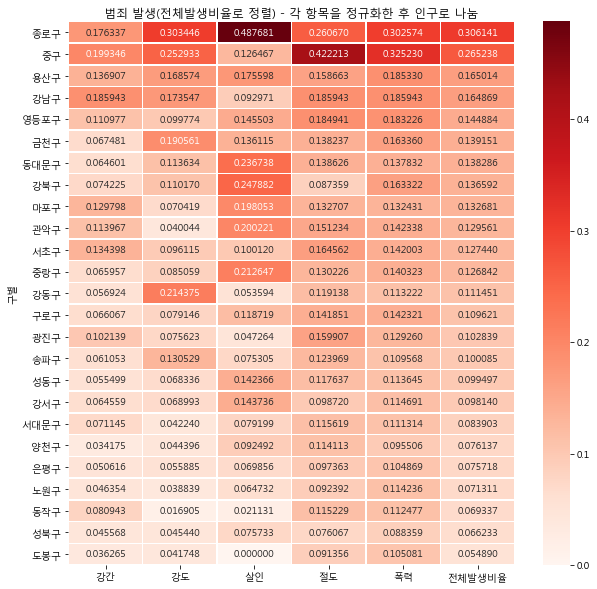

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc # rc == run configure(configuration file)
%matplotlib inline 

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


df = pd.read_excel('관서별 5대범죄 발생 및 검거.xlsx') # 엑셀 파일 읽기?


police_to_gu = {'서대문서': '서대문구', '수서서': '강남구', '강서서': '강서구', '서초서': '서초구',
                '서부서': '은평구', '중부서': '중구', '종로서': '종로구', '남대문서': '중구',
                '혜화서': '종로구', '용산서': '용산구', '성북서': '성북구', '동대문서': '동대문구',
                '마포서': '마포구', '영등포서': '영등포구', '성동서': '성동구', '동작서': '동작구',
                '광진서': '광진구', '강북서': '강북구', '금천서': '금천구', '중랑서': '중랑구',
                '강남서': '강남구', '관악서': '관악구', '강동서': '강동구', '종암서': '성북구', 
                '구로서': '구로구', '양천서': '양천구', '송파서': '송파구', '노원서': '노원구', 
                '방배서': '서초구', '은평서': '은평구', '도봉서': '도봉구'}


df['구별'] = df['관서명'].apply(lambda x: police_to_gu.get(x, '구 없음')) # 적용하다? 
gu_df = pd.pivot_table(df, index='구별', aggfunc=np.sum) # 피봇 테이블을 만드려면?

gu_df = gu_df.drop(['구 없음']) # 행을 삭제할 때? (Database)


gu_df['강간검거율'] = gu_df['강간(검거)']/gu_df['강간(발생)']*100
gu_df['강도검거율'] = gu_df['강도(검거)']/gu_df['강도(발생)']*100
gu_df['살인검거율'] = gu_df['살인(검거)']/gu_df['살인(발생)']*100
gu_df['절도검거율'] = gu_df['절도(검거)']/gu_df['절도(발생)']*100
gu_df['폭력검거율'] = gu_df['폭력(검거)']/gu_df['폭력(발생)']*100
gu_df['검거율'] = gu_df['소계(검거)']/gu_df['소계(발생)']*100

del gu_df['강간(검거)']
del gu_df['강도(검거)']
del gu_df['살인(검거)']
del gu_df['절도(검거)']
del gu_df['폭력(검거)']
del gu_df['소계(발생)']
del gu_df['소계(검거)']


gu_df[ gu_df[['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']] > 100 ] = 100

gu_df.rename(columns = {'강간(발생)':'강간',
                        '강도(발생)':'강도',
                        '살인(발생)':'살인',
                        '절도(발생)':'절도',
                        '폭력(발생)':'폭력'}, inplace=True) # inplace 옵션 == 덮어쓰기 여부


popul_df = pd.read_csv('pop_kor.csv', encoding='utf-8', index_col='구별')
gu_df = gu_df.join(popul_df)

weight_col = gu_df[['강간', '강도', '살인', '절도', '폭력']].max()
crime_count_norm = gu_df[['강간', '강도', '살인', '절도', '폭력']] / weight_col

crime_ratio = crime_count_norm.div(gu_df['인구수'], axis=0) * 100000 
crime_ratio['전체발생비율'] = crime_ratio.mean(axis=1) # 평균?


plt.figure(figsize = (10,10))
sns.heatmap(crime_ratio.sort_values(by='전체발생비율', ascending=False), annot=True, fmt='f', linewidths=.5, cmap='Reds')
plt.title('범죄 발생(전체발생비율로 정렬) - 각 항목을 정규화한 후 인구로 나눔')
plt.show()

<br>

#### (Extra 2) 상세 버전 GeoJSON 활용 (not simplified version)

- 위에서 활용한 [ skorea_municipalities_geo_simple.json ] 파일은 단순화된 GeoJSON 파일입니다.
- 해당 파일 대신 **보다 상세한 좌표값을 갖고 있는 상세 버전 GeoJSON 파일**을 활용할 수 있습니다. 
- 원본 파일 URL : https://github.com/southkorea/southkorea-maps/tree/master/kostat/2018/json (-> 파일 이름 변경됨)

|파일명|단순/상세|행정구역 단위|
|---|---|---|
|skorea_municipalities_geo_**simple**.json|단순 (기존 실습)|별도로 편집하여 **서울시 내 [구]**만 추출|
|skorea-2018-**provinces**-geo.json|상세|**특별시/광역시/특별자치시 + 도/특별자치도**|
|skorea-2018-**municipalities**-geo.json|상세 (하단 실습)|**시/군/구**|
|skorea-2018-**submunicipalities**-geo.json|상세|**읍/면/동/리**|

In [2]:
import json
import folium

geo_path = 'skorea-2018-municipalities-geo.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

In [ ]:
# geo_str['features'][0] # detailed coordinates

In [ ]:
# for feature in geo_str['features']:
#     print(feature['properties'])

In [3]:
in_seoul = [] # 서울 내 지역만 모을 리스트

for feature in geo_str['features']:
    if feature['properties']['code'].startswith('11'): # 서울 내 지역의 경우 code가 11로 시작 (11010~11250)
        in_seoul.append(feature)
        
del geo_str['features']
geo_str['features'] = in_seoul

In [4]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles='Stamen Toner')

map.choropleth(geo_data = geo_str,               
               data = crime_ratio['전체발생비율'], 
               columns = [crime_ratio.index, crime_ratio['전체발생비율']],
               fill_color = 'PuRd',
               
               key_on = 'feature.properties.name')
               # geo_str['features'][0] -> {..., 'properties': {'name': '종로구', ...}} <- properties.name 에 대응됩니다.
map